In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

extract_path = r'/content/drive/MyDrive/project_tts/emotion_tts/data'
os.makedirs(extract_path, exist_ok=True)


In [5]:
import tarfile

input_tar_bz2_path = r'/content/drive/MyDrive/project_tts/LJSpeech-1.1.tar.bz2'

# 압축 해제
# with tarfile.open(input_tar_bz2_path, 'r:bz2') as tar :
#   tar.extractall(path=extract_path)

In [6]:
!pip install torch torchaudio librosa matplotlib tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 853.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [7]:
!pip install unidecode soundfile tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.3 MB/s eta 0:00:00


In [3]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

CUDA available: True
GPU: Tesla T4


In [4]:
import os

# 데이터 확인
from pathlib import Path
wav_files = list(Path(r'/content/drive/MyDrive/project_tts/emotion_tts/data/LJSpeech-1.1/wavs').glob('*.wav'))
print(f"Total audio files: {len(wav_files)}")

Total audio files: 13100


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import matplotlib.pyplot as plt
from pathlib import Path
import os

metadata = r'/content/drive/MyDrive/project_tts/emotion_tts/data/LJSpeech-1.1/metadata.csv'

# 메타 데이터 미리보기
with open(metadata, 'r') as f :
  for i, line in enumerate(f) :
    if i < 3 :
      print(f'Sample { i+1} : {line.strip()}')

Sample 1 : LJ001-0001|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Sample 2 : LJ001-0002|in being comparatively modern.|in being comparatively modern.
Sample 3 : LJ001-0003|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process


# 🧐 코드 설명
```python
with open(metadata, 'r') as f :
  for i, line in enumerate(f) :
    if i < 3 :
      print(f'Sample { i+1} : {line.strip()}')
```

## 각 부분 설명
```python
with open(metadata, 'r') as f :
```
- `metadata` 라는 파일을 읽기 모드 `'r'`로 연다
- `with` 문을 사용하여 파일을 열면, 파일을 다 사용한 후 자동으로 닫아준다
- `f` 는 파일 객체

```python
  for i, line in enumerate(f) :
```
- 파일의 각 줄을 하나씩 읽어오며, i는 줄 번호(0부터 시작), line은 각 줄의 내용
- enumerate()는 각 줄에 인덱스를 붙여준다

```python
if i < 3 :
      print(f'Sample { i+1} : {line.strip()}')
```
- 처음 3줄까지만 출력하겠다는 의미
- 줄의 앞뒤 공백 문자(줄바꿈 포함)를 제거한 후 출력
- 1부터 시작하는 번호로 출력

In [8]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.3 MB/s eta 0:00:00


In [9]:
from unidecode import unidecode
import re

class SimpleTextProcessor:
    def __init__(self):
        # 기본 문자들 + 특수문자 (소문자만)
        self.symbols = [
            'PAD', 'EOS',  # 패딩과 끝 토큰
            ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.', ':', ';', '?',  # 구두점
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
        ]
        self.char_to_id = {char: i for i, char in enumerate(self.symbols)}
        self.id_to_char = {i: char for i, char in enumerate(self.symbols)}

    def clean_text(self, text):
        """텍스트 정리"""
        text = unidecode(text)  # 악센트 제거
        text = text.lower()     # 소문자 변환
        text = re.sub(r'[^a-z\s\.,!?;:\'-]', '', text)  # 허용된 문자만
        text = re.sub(r'\s+', ' ', text).strip()        # 공백 정리
        return text

    def text_to_sequence(self, text):
        """텍스트를 숫자 시퀀스로 변환"""
        text = self.clean_text(text)
        sequence = []
        for char in text:
            if char in self.char_to_id:
                sequence.append(self.char_to_id[char])
            else:
                sequence.append(self.char_to_id[' '])  # 모르는 문자는 공백으로
        sequence.append(self.char_to_id['EOS'])  # 끝 토큰 추가
        return sequence

    def sequence_to_text(self, sequence):
        """숫자 시퀀스를 텍스트로 변환"""
        return ''.join([self.id_to_char.get(id, '') for id in sequence])

# 테스트
text_processor = SimpleTextProcessor()
print(f"Vocabulary size: {len(text_processor.symbols)}")

# 샘플 텍스트로 테스트
sample_text = "Printing, in the only sense with which we are at present concerned"
sequence = text_processor.text_to_sequence(sample_text)
restored_text = text_processor.sequence_to_text(sequence)

print(f"Original: {sample_text}")
print(f"Cleaned: {text_processor.clean_text(sample_text)}")
print(f"Sequence length: {len(sequence)}")
print(f"Restored: {restored_text}")

Vocabulary size: 41
Original: Printing, in the only sense with which we are at present concerned
Cleaned: printing, in the only sense with which we are at present concerned
Sequence length: 67
Restored: printing, in the only sense with which we are at present concernedEOS


Mel spectrogram shape: (80, 832)
Value range: -80.00 ~ 0.00 dB


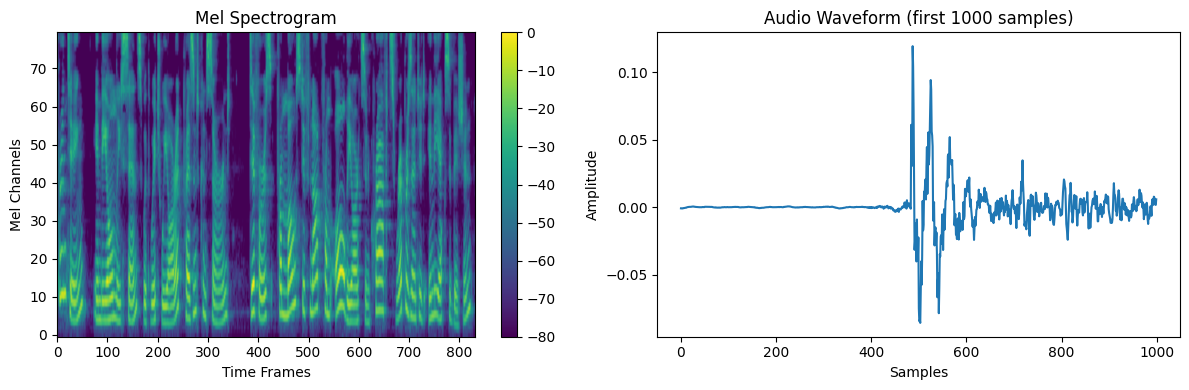

In [10]:
import librosa
import numpy as np

class AudioProcessor:
    def __init__(self,
                 sample_rate=22050,
                 n_fft=1024,
                 hop_length=256,
                 win_length=1024,
                 n_mels=80,
                 fmin=0.0,
                 fmax=8000.0):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax

    def load_audio(self, audio_path):
        """음성 파일 로드"""
        audio, sr = librosa.load(audio_path, sr=self.sample_rate)
        # 볼륨 정규화
        audio = librosa.util.normalize(audio)
        return audio

    def audio_to_melspec(self, audio):
        """오디오를 멜 스펙트로그램으로 변환"""
        # STFT 후 멜 필터뱅크 적용
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax
        )

        # dB 스케일 변환
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec_db

    def load_audio_and_melspec(self, audio_path):
        """파일에서 바로 멜 스펙트로그램 추출"""
        audio = self.load_audio(audio_path)
        mel_spec = self.audio_to_melspec(audio)
        return mel_spec

# 테스트
audio_processor = AudioProcessor()

# 첫 번째 오디오 파일로 테스트
test_audio_path = '/content/drive/MyDrive/project_tts/emotion_tts/data/LJSpeech-1.1/wavs/LJ001-0001.wav'
mel_spec = audio_processor.load_audio_and_melspec(test_audio_path)

print(f"Mel spectrogram shape: {mel_spec.shape}")  # (80, time_steps)
print(f"Value range: {mel_spec.min():.2f} ~ {mel_spec.max():.2f} dB")

# 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
plt.title('Mel Spectrogram')
plt.ylabel('Mel Channels')
plt.xlabel('Time Frames')
plt.colorbar()

plt.subplot(1, 2, 2)
# 원본 오디오도 확인
audio = audio_processor.load_audio(test_audio_path)
plt.plot(audio[:1000])  # 처음 1000 샘플만
plt.title('Audio Waveform (first 1000 samples)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch
import random

class LJSpeechDataset(Dataset):
    def __init__(self, metadata_path, audio_dir, text_processor, audio_processor, max_samples=None):
        self.audio_dir = Path(audio_dir)
        self.text_processor = text_processor
        self.audio_processor = audio_processor
        self.data = []

        # 메타데이터 로드
        with open(metadata_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        # 필요하면 샘플 수 제한 (테스트용)
        if max_samples:
            lines = lines[:max_samples]

        for line in lines:
            parts = line.strip().split('|')
            if len(parts) >= 2:
                filename = parts[0]
                text = parts[1]  # 정규화된 텍스트 사용

                audio_path = self.audio_dir / f'{filename}.wav'
                if audio_path.exists():
                    self.data.append({
                        'filename': filename,
                        'text': text,
                        'audio_path': str(audio_path)
                    })

        print(f"Dataset loaded: {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # 텍스트 처리
        text_sequence = self.text_processor.text_to_sequence(item['text'])

        # 오디오 처리
        mel_spec = self.audio_processor.load_audio_and_melspec(item['audio_path'])

        return {
            'filename': item['filename'],
            'text': item['text'],
            'text_sequence': torch.LongTensor(text_sequence),
            'mel_spec': torch.FloatTensor(mel_spec.T),  # (time, n_mels)로 transpose
            'text_length': len(text_sequence),
            'mel_length': mel_spec.shape[1]
        }

# 테스트용으로 작은 데이터셋 만들기
dataset = LJSpeechDataset(
    metadata_path='/content/drive/MyDrive/project_tts/emotion_tts/data/LJSpeech-1.1/metadata.csv',
    audio_dir='/content/drive/MyDrive/project_tts/emotion_tts/data/LJSpeech-1.1/wavs',
    text_processor=text_processor,
    audio_processor=audio_processor,
    max_samples=100  # 테스트용으로 100개만
)

# 샘플 확인
sample = dataset[0]
print(f"Sample filename: {sample['filename']}")
print(f"Original text: {sample['text']}")
print(f"Text sequence length: {sample['text_length']}")
print(f"Mel spectrogram shape: {sample['mel_spec'].shape}")
print(f"Mel length: {sample['mel_length']}")

Dataset loaded: 100 samples
Sample filename: LJ001-0001
Original text: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Text sequence length: 152
Mel spectrogram shape: torch.Size([832, 80])
Mel length: 832


In [12]:
def collate_fn(batch):
    """배치 데이터를 패딩해서 동일한 크기로 만들기"""

    # 배치에서 각 요소 추출
    filenames = [item['filename'] for item in batch]
    texts = [item['text'] for item in batch]
    text_sequences = [item['text_sequence'] for item in batch]
    mel_specs = [item['mel_spec'] for item in batch]
    text_lengths = [item['text_length'] for item in batch]
    mel_lengths = [item['mel_length'] for item in batch]

    # 텍스트 패딩
    max_text_length = max(text_lengths)
    batch_size = len(batch)

    padded_text_sequences = torch.zeros(batch_size, max_text_length, dtype=torch.long)
    for i, seq in enumerate(text_sequences):
        padded_text_sequences[i, :len(seq)] = seq

    # 멜 스펙트로그램 패딩
    max_mel_length = max(mel_lengths)
    n_mels = mel_specs[0].size(1)  # 80

    padded_mel_specs = torch.zeros(batch_size, max_mel_length, n_mels)
    for i, mel in enumerate(mel_specs):
        padded_mel_specs[i, :mel.size(0), :] = mel

    return {
        'filenames': filenames,
        'texts': texts,
        'text_sequences': padded_text_sequences,
        'mel_specs': padded_mel_specs,
        'text_lengths': torch.LongTensor(text_lengths),
        'mel_lengths': torch.LongTensor(mel_lengths)
    }

# 데이터로더 테스트
test_dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

# 첫 번째 배치 확인
for batch in test_dataloader:
    print("=== First Batch ===")
    print(f"Batch size: {len(batch['filenames'])}")
    print(f"Text sequences shape: {batch['text_sequences'].shape}")
    print(f"Mel specs shape: {batch['mel_specs'].shape}")
    print(f"Text lengths: {batch['text_lengths']}")
    print(f"Mel lengths: {batch['mel_lengths']}")

    print(f"\nSample texts:")
    for i, text in enumerate(batch['texts'][:2]):  # 처음 2개만
        print(f"  {i+1}: {text}")

    break  # 첫 번째 배치만 확인

=== First Batch ===
Batch size: 4
Text sequences shape: torch.Size([4, 114])
Mel specs shape: torch.Size([4, 665, 80])
Text lengths: tensor([101, 102, 114,  89])
Mel lengths: tensor([627, 665, 635, 614])

Sample texts:
  1: and though the famous family of Aldus restored its technical excellence, rejecting battered letters,
  2: After his death in the "fourteen eighties," or at least by 1490, printing in Venice had declined very much;


In [13]:
import torch.nn as nn
import torch.optim as optim

class SimpleLinearTTS(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, n_mels=80):
        super(SimpleLinearTTS, self).__init__()

        # 텍스트 임베딩
        self.text_embedding = nn.Embedding(vocab_size, hidden_dim)

        # 간단한 인코더 (텍스트 → 고정 크기 벡터)
        self.text_encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # 디코더 (고정 벡터 → 멜 스펙트로그램)
        self.mel_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, n_mels)
        )

    def forward(self, text_sequences, text_lengths, mel_target_lengths=None):
        batch_size = text_sequences.size(0)

        # 텍스트 임베딩
        text_embedded = self.text_embedding(text_sequences)  # (batch, seq_len, hidden)

        # 평균 풀링으로 고정 크기 벡터 만들기
        text_encoded = text_embedded.mean(dim=1)  # (batch, hidden)

        # 텍스트 인코딩
        text_features = self.text_encoder(text_encoded)  # (batch, hidden)

        # 멜 스펙트로그램 디코딩 (1 프레임만 생성)
        mel_frame = self.mel_decoder(text_features)  # (batch, n_mels)

        # 타겟 길이만큼 반복 (실제로는 attention으로 해야 하지만 간단히)
        if mel_target_lengths is not None:
            max_mel_length = mel_target_lengths.max().item()
        else:
            max_mel_length = text_lengths.max().item() * 4  # 대략적인 비율

        mel_output = mel_frame.unsqueeze(1).expand(batch_size, max_mel_length, -1)

        return mel_output

# 모델 생성
vocab_size = len(text_processor.symbols)
model = SimpleLinearTTS(vocab_size=vocab_size, hidden_dim=128, n_mels=80)

# 모델 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {total_params:,}")

# 테스트 forward pass
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 테스트 배치로 forward 해보기
for batch in test_dataloader:
    text_sequences = batch['text_sequences'].to(device)
    mel_specs = batch['mel_specs'].to(device)
    text_lengths = batch['text_lengths'].to(device)
    mel_lengths = batch['mel_lengths'].to(device)

    # Forward pass
    mel_output = model(text_sequences, text_lengths, mel_lengths)

    print(f"Input text shape: {text_sequences.shape}")
    print(f"Target mel shape: {mel_specs.shape}")
    print(f"Output mel shape: {mel_output.shape}")
    print(f"Model output range: {mel_output.min().item():.3f} ~ {mel_output.max().item():.3f}")

    break  # 첫 번째 배치만 테스트

Model parameters: 243,920
Input text shape: torch.Size([4, 90])
Target mel shape: torch.Size([4, 443, 80])
Output mel shape: torch.Size([4, 443, 80])
Model output range: -0.082 ~ 0.068


In [14]:
import torch.nn.functional as F
from tqdm import tqdm
import time

class SimpleTTSLoss(nn.Module):
    def __init__(self):
        super(SimpleTTSLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, mel_pred, mel_target):
        # 예측과 타겟의 길이를 맞춰주기
        min_length = min(mel_pred.size(1), mel_target.size(1))

        mel_pred_cropped = mel_pred[:, :min_length, :]
        mel_target_cropped = mel_target[:, :min_length, :]

        loss = self.mse_loss(mel_pred_cropped, mel_target_cropped)
        return loss

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)

    with tqdm(dataloader, desc="Training") as pbar:
        for batch_idx, batch in enumerate(pbar):
            # 데이터를 GPU로 이동
            text_sequences = batch['text_sequences'].to(device)
            mel_specs = batch['mel_specs'].to(device)
            text_lengths = batch['text_lengths'].to(device)
            mel_lengths = batch['mel_lengths'].to(device)

            # Forward pass
            mel_pred = model(text_sequences, text_lengths, mel_lengths)

            # 손실 계산
            loss = criterion(mel_pred, mel_specs)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 진행상황 업데이트
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

            # 메모리 절약을 위해 가끔씩 캐시 클리어
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()

    return total_loss / num_batches

# 학습 설정
criterion = SimpleTTSLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("=== Starting Training ===")
print(f"Device: {device}")
print(f"Dataset size: {len(dataset)}")
print(f"Model parameters: {total_params:,}")

=== Starting Training ===
Device: cuda
Dataset size: 100
Model parameters: 243,920



Epoch 1/3
----------------------------------------


Training: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it, Loss=748.6918]


Average Loss: 2113.1306
Time: 54.86s
Learning Rate: 0.001000

Epoch 2/3
----------------------------------------


Training: 100%|██████████| 25/25 [00:02<00:00,  8.42it/s, Loss=645.5165]


Average Loss: 688.4715
Time: 2.98s
Learning Rate: 0.001000

Epoch 3/3
----------------------------------------


Training: 100%|██████████| 25/25 [00:01<00:00, 14.16it/s, Loss=709.7584]


Average Loss: 623.4081
Time: 1.77s
Learning Rate: 0.001000

=== Training Completed! ===


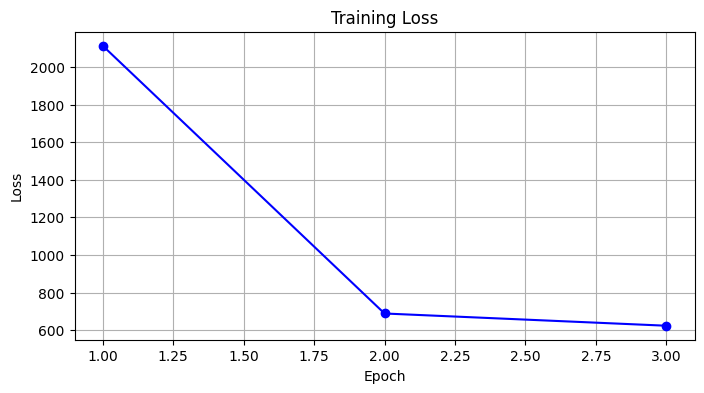

Model saved as 'simple_tts_model.pth'


In [15]:
# 학습 시작!
num_epochs = 3  # 일단 3 에포크만 테스트

train_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    start_time = time.time()

    # 한 에포크 학습
    avg_loss = train_one_epoch(model, test_dataloader, optimizer, criterion, device)

    epoch_time = time.time() - start_time
    train_losses.append(avg_loss)

    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Time: {epoch_time:.2f}s")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

print("\n=== Training Completed! ===")

# 학습 곡선 그리기
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 모델 저장
torch.save(model.state_dict(), 'simple_tts_model.pth')
print("Model saved as 'simple_tts_model.pth'")

In [16]:
def inference_tts(model, text, text_processor, device, target_length=None):
    """텍스트에서 멜 스펙트로그램 생성"""
    model.eval()

    with torch.no_grad():
        # 텍스트 전처리
        text_sequence = text_processor.text_to_sequence(text)
        text_tensor = torch.LongTensor(text_sequence).unsqueeze(0).to(device)  # (1, seq_len)
        text_length = torch.LongTensor([len(text_sequence)]).to(device)

        # 타겟 길이 설정 (텍스트 길이의 4배 정도)
        if target_length is None:
            target_length = len(text_sequence) * 4

        mel_target_length = torch.LongTensor([target_length]).to(device)

        # 모델 추론
        mel_output = model(text_tensor, text_length, mel_target_length)

        return mel_output.squeeze(0).cpu().numpy()  # (time, n_mels)

# 테스트할 문장들
test_texts = [
    "Hello world!",
    "This is a test sentence.",
    "How are you today?",
    "The weather is nice.",
    "I love machine learning."
]

print("=== TTS Inference Test ===\n")

# 각 문장별로 추론 테스트
results = []

for i, text in enumerate(test_texts):
    print(f"Text {i+1}: '{text}'")

    # 추론 실행
    mel_pred = inference_tts(model, text, text_processor, device, target_length=100)

    print(f"  Generated mel shape: {mel_pred.shape}")
    print(f"  Mel value range: {mel_pred.min():.3f} ~ {mel_pred.max():.3f}")

    results.append({
        'text': text,
        'mel': mel_pred
    })

    print()

print("Inference completed!")

=== TTS Inference Test ===

Text 1: 'Hello world!'
  Generated mel shape: (100, 80)
  Mel value range: -47.395 ~ -26.464

Text 2: 'This is a test sentence.'
  Generated mel shape: (100, 80)
  Mel value range: -72.375 ~ -40.416

Text 3: 'How are you today?'
  Generated mel shape: (100, 80)
  Mel value range: -63.194 ~ -35.299

Text 4: 'The weather is nice.'
  Generated mel shape: (100, 80)
  Mel value range: -65.118 ~ -36.358

Text 5: 'I love machine learning.'
  Generated mel shape: (100, 80)
  Mel value range: -62.654 ~ -34.980

Inference completed!


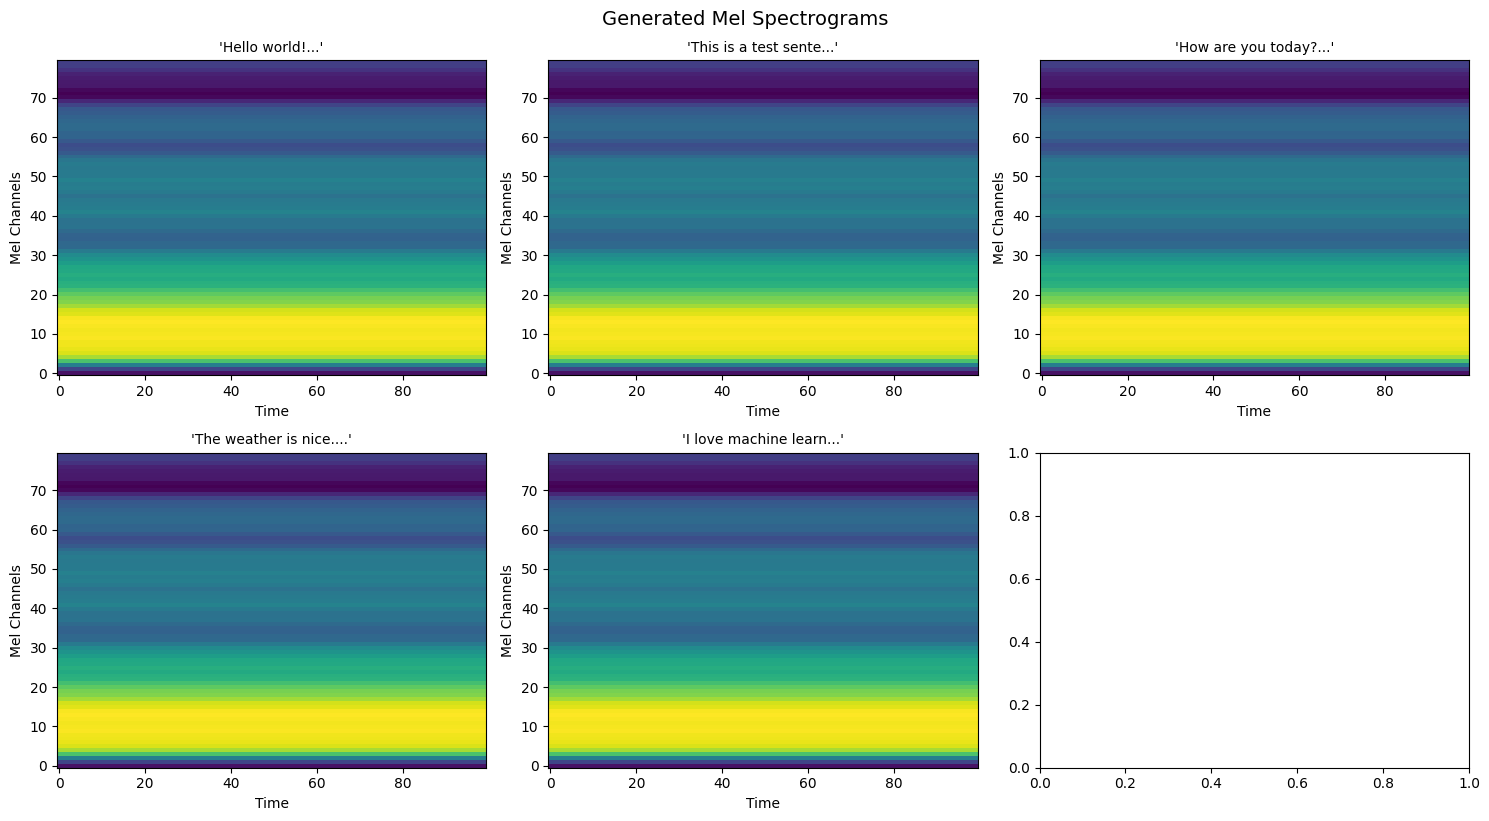


=== Comparison with Real Data ===
Real text: 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'
Real mel shape: (832, 80)
Generated mel shape: (832, 80)


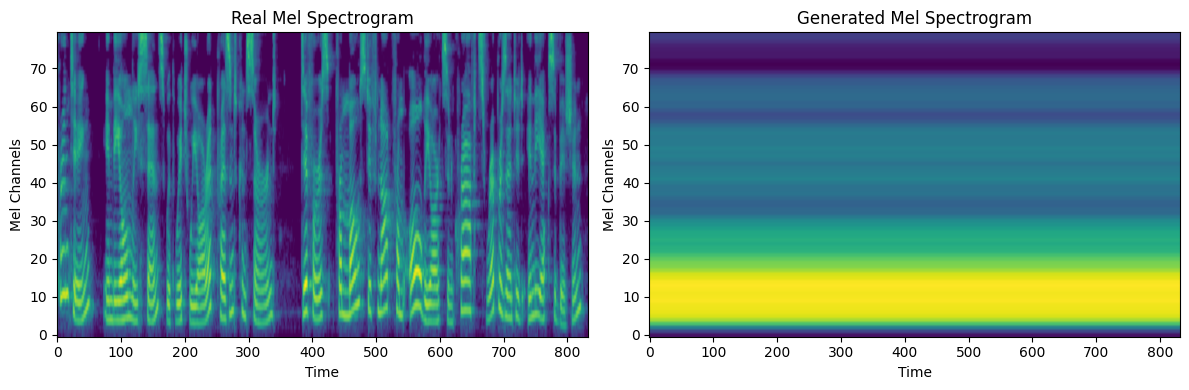


Real mel range: -80.000 ~ 0.000
Generated mel range: -69.940 ~ -39.054


In [17]:
# 생성된 멜 스펙트로그램 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, result in enumerate(results[:6]):  # 첫 5개 + 1개 빈 공간
    if i < len(results):
        mel = result['mel']
        text = result['text']

        axes[i].imshow(mel.T, aspect='auto', origin='lower', cmap='viridis')
        axes[i].set_title(f"'{text[:20]}...'", fontsize=10)
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Mel Channels')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Generated Mel Spectrograms', fontsize=14, y=1.02)
plt.show()

# 실제 데이터와 비교해보기
print("\n=== Comparison with Real Data ===")

# 실제 데이터 샘플 가져오기
real_sample = dataset[0]
real_mel = real_sample['mel_spec'].numpy()
real_text = real_sample['text']

# 같은 길이로 생성해보기
test_mel = inference_tts(model, real_text, text_processor, device, target_length=real_mel.shape[0])

print(f"Real text: '{real_text}'")
print(f"Real mel shape: {real_mel.shape}")
print(f"Generated mel shape: {test_mel.shape}")

# 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(real_mel.T, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Real Mel Spectrogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mel Channels')

axes[1].imshow(test_mel.T, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Generated Mel Spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Channels')

plt.tight_layout()
plt.show()

print(f"\nReal mel range: {real_mel.min():.3f} ~ {real_mel.max():.3f}")
print(f"Generated mel range: {test_mel.min():.3f} ~ {test_mel.max():.3f}")

In [18]:
class EmotionLinearTTS(nn.Module):
    def __init__(self, vocab_size, n_emotions=5, hidden_dim=256, n_mels=80):
        super(EmotionLinearTTS, self).__init__()

        # 감정 정의
        self.emotion_names = ['neutral', 'happy', 'sad', 'angry', 'surprised']
        self.n_emotions = n_emotions

        # 텍스트 임베딩
        self.text_embedding = nn.Embedding(vocab_size, hidden_dim)

        # 감정 임베딩
        self.emotion_embedding = nn.Embedding(n_emotions, hidden_dim)

        # 텍스트 인코더
        self.text_encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # 감정 조건부 결합층
        self.emotion_fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # 텍스트 + 감정
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # 멜 디코더 (감정에 따라 다르게 생성)
        self.mel_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, n_mels)
        )

    def forward(self, text_sequences, emotion_ids, text_lengths, mel_target_lengths=None):
        batch_size = text_sequences.size(0)

        # 텍스트 임베딩
        text_embedded = self.text_embedding(text_sequences)  # (batch, seq_len, hidden)
        text_encoded = text_embedded.mean(dim=1)  # (batch, hidden)
        text_features = self.text_encoder(text_encoded)  # (batch, hidden)

        # 감정 임베딩
        emotion_embedded = self.emotion_embedding(emotion_ids)  # (batch, hidden)

        # 텍스트 + 감정 결합
        combined_features = torch.cat([text_features, emotion_embedded], dim=1)  # (batch, hidden*2)
        fused_features = self.emotion_fusion(combined_features)  # (batch, hidden)

        # 멜 스펙트로그램 생성
        mel_frame = self.mel_decoder(fused_features)  # (batch, n_mels)

        # 타겟 길이만큼 확장
        if mel_target_lengths is not None:
            max_mel_length = mel_target_lengths.max().item()
        else:
            max_mel_length = text_lengths.max().item() * 4

        mel_output = mel_frame.unsqueeze(1).expand(batch_size, max_mel_length, -1)

        return mel_output

# 새로운 감정 조건부 모델 생성
emotion_model = EmotionLinearTTS(vocab_size=vocab_size, n_emotions=5, hidden_dim=128, n_mels=80)
emotion_model = emotion_model.to(device)

# 모델 파라미터 수 확인
emotion_params = sum(p.numel() for p in emotion_model.parameters() if p.requires_grad)
print(f"Emotion model parameters: {emotion_params:,}")
print(f"Emotion classes: {emotion_model.emotion_names}")

Emotion model parameters: 277,456
Emotion classes: ['neutral', 'happy', 'sad', 'angry', 'surprised']


In [20]:
import random

class EmotionDataset(Dataset):
    def __init__(self, original_dataset, emotion_model):
        self.original_dataset = original_dataset
        self.emotion_names = emotion_model.emotion_names
        self.n_emotions = emotion_model.n_emotions

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # 원본 데이터 가져오기
        original_item = self.original_dataset[idx]

        # 랜덤하게 감정 할당 (실제로는 감정 라벨이 있는 데이터를 사용해야 함)
        emotion_id = random.randint(0, self.n_emotions - 1)

        return {
            'filename': original_item['filename'],
            'text': original_item['text'],
            'text_sequence': original_item['text_sequence'],
            'mel_spec': original_item['mel_spec'],
            'text_length': original_item['text_length'],
            'mel_length': original_item['mel_length'],
            'emotion_id': emotion_id,
            'emotion_name': self.emotion_names[emotion_id]
        }

def emotion_collate_fn(batch):
    """감정 정보를 포함한 콜레이트 함수"""

    # 기본 데이터
    filenames = [item['filename'] for item in batch]
    texts = [item['text'] for item in batch]
    text_sequences = [item['text_sequence'] for item in batch]
    mel_specs = [item['mel_spec'] for item in batch]
    text_lengths = [item['text_length'] for item in batch]
    mel_lengths = [item['mel_length'] for item in batch]

    # 감정 데이터
    emotion_ids = [item['emotion_id'] for item in batch]
    emotion_names = [item['emotion_name'] for item in batch]

    # 패딩
    max_text_length = max(text_lengths)
    batch_size = len(batch)

    padded_text_sequences = torch.zeros(batch_size, max_text_length, dtype=torch.long)
    for i, seq in enumerate(text_sequences):
        padded_text_sequences[i, :len(seq)] = seq

    max_mel_length = max(mel_lengths)
    n_mels = mel_specs[0].size(1)

    padded_mel_specs = torch.zeros(batch_size, max_mel_length, n_mels)
    for i, mel in enumerate(mel_specs):
        padded_mel_specs[i, :mel.size(0), :] = mel

    return {
        'filenames': filenames,
        'texts': texts,
        'text_sequences': padded_text_sequences,
        'mel_specs': padded_mel_specs,
        'text_lengths': torch.LongTensor(text_lengths),
        'mel_lengths': torch.LongTensor(mel_lengths),
        'emotion_ids': torch.LongTensor(emotion_ids),
        'emotion_names': emotion_names
    }

# 감정 데이터셋 생성
emotion_dataset = EmotionDataset(dataset, emotion_model)

# 감정 데이터로더 생성
emotion_dataloader = DataLoader(
    emotion_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=emotion_collate_fn
)

# 감정 데이터 확인
print("=== Emotion Dataset Test ===")
for batch in emotion_dataloader:
    print(f"Batch size: {len(batch['filenames'])}")
    print(f"Emotion IDs: {batch['emotion_ids']}")
    print(f"Emotion names: {batch['emotion_names']}")
    print(f"Sample texts:")
    for i, (text, emotion) in enumerate(zip(batch['texts'][:2], batch['emotion_names'][:2])):
        print(f"  {i+1}. [{emotion}] {text}")
    break

=== Emotion Dataset Test ===
Batch size: 4
Emotion IDs: tensor([2, 0, 4, 4])
Emotion names: ['sad', 'neutral', 'surprised', 'surprised']
Sample texts:
  1. [sad] The Roman type of all these printers is similar in character,
  2. [neutral] But about the same year Mentelin at Strasburg began to print in a type which is distinctly Roman;


=== Emotion-Conditioned Training ===

Epoch 1/3
--------------------------------------------------


Training with Emotions: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s, Loss=754.9436, Emotions=3/5]


Average Loss: 1923.3521
Time: 2.95s
Emotion distribution this epoch:
  neutral: 22
  happy: 16
  sad: 19
  angry: 20
  surprised: 23

Epoch 2/3
--------------------------------------------------


Training with Emotions: 100%|██████████| 25/25 [00:01<00:00, 12.87it/s, Loss=741.1113, Emotions=3/5]


Average Loss: 705.5134
Time: 1.95s
Emotion distribution this epoch:
  neutral: 23
  happy: 27
  sad: 18
  angry: 13
  surprised: 19

Epoch 3/3
--------------------------------------------------


Training with Emotions: 100%|██████████| 25/25 [00:01<00:00, 13.44it/s, Loss=727.5275, Emotions=3/5]


Average Loss: 614.3469
Time: 1.87s
Emotion distribution this epoch:
  neutral: 21
  happy: 20
  sad: 22
  angry: 22
  surprised: 15

=== Emotion Training Completed! ===


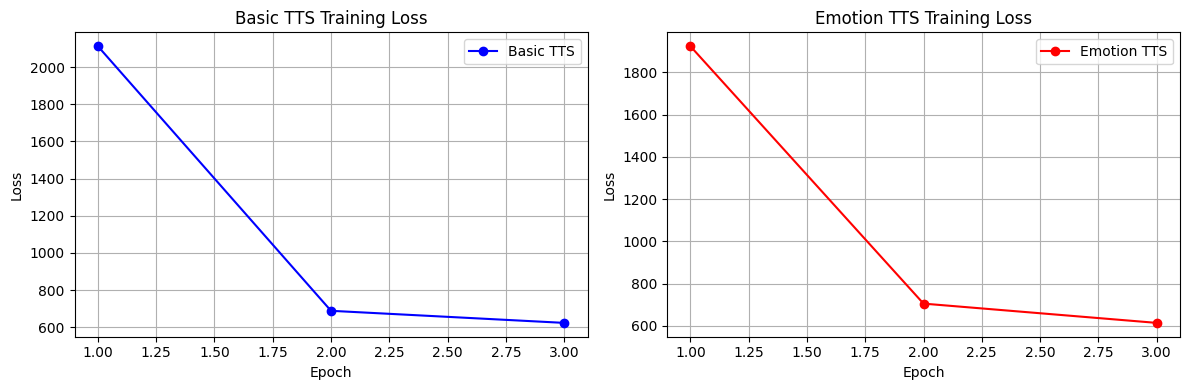

Emotion model saved as 'emotion_tts_model.pth'


In [21]:
def train_emotion_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    emotion_counts = {name: 0 for name in model.emotion_names}

    with tqdm(dataloader, desc="Training with Emotions") as pbar:
        for batch_idx, batch in enumerate(pbar):
            # 데이터를 GPU로 이동
            text_sequences = batch['text_sequences'].to(device)
            mel_specs = batch['mel_specs'].to(device)
            text_lengths = batch['text_lengths'].to(device)
            mel_lengths = batch['mel_lengths'].to(device)
            emotion_ids = batch['emotion_ids'].to(device)

            # 감정 분포 카운트
            for emotion_name in batch['emotion_names']:
                emotion_counts[emotion_name] += 1

            # Forward pass (감정 조건 추가!)
            mel_pred = model(text_sequences, emotion_ids, text_lengths, mel_lengths)

            # 손실 계산
            loss = criterion(mel_pred, mel_specs)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 진행상황 업데이트
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Emotions': f'{len(set(batch["emotion_names"]))}/5'
            })

    return total_loss / len(dataloader), emotion_counts

# 감정 조건부 학습 시작
print("=== Emotion-Conditioned Training ===")

emotion_criterion = SimpleTTSLoss()
emotion_optimizer = optim.Adam(emotion_model.parameters(), lr=1e-3)

num_epochs = 3
emotion_train_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    start_time = time.time()

    # 감정 조건부 학습
    avg_loss, emotion_counts = train_emotion_epoch(
        emotion_model, emotion_dataloader, emotion_optimizer, emotion_criterion, device
    )

    epoch_time = time.time() - start_time
    emotion_train_losses.append(avg_loss)

    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Time: {epoch_time:.2f}s")
    print(f"Emotion distribution this epoch:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count}")

print("\n=== Emotion Training Completed! ===")

# 학습 곡선 비교
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Basic TTS')
plt.title('Basic TTS Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(emotion_train_losses)+1), emotion_train_losses, 'r-o', label='Emotion TTS')
plt.title('Emotion TTS Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 감정 모델 저장
torch.save(emotion_model.state_dict(), 'emotion_tts_model.pth')
print("Emotion model saved as 'emotion_tts_model.pth'")

In [22]:
def inference_emotion_tts(model, text, emotion_id, text_processor, device, target_length=None):
    """감정 조건부 TTS 추론"""
    model.eval()

    with torch.no_grad():
        # 텍스트 전처리
        text_sequence = text_processor.text_to_sequence(text)
        text_tensor = torch.LongTensor(text_sequence).unsqueeze(0).to(device)
        text_length = torch.LongTensor([len(text_sequence)]).to(device)

        # 감정 ID
        emotion_tensor = torch.LongTensor([emotion_id]).to(device)

        # 타겟 길이 설정
        if target_length is None:
            target_length = len(text_sequence) * 4

        mel_target_length = torch.LongTensor([target_length]).to(device)

        # 모델 추론
        mel_output = model(text_tensor, emotion_tensor, text_length, mel_target_length)

        return mel_output.squeeze(0).cpu().numpy()

# 감정별 추론 테스트
print("=== Emotion-Conditioned Inference Test ===\n")

test_text = "Hello, how are you today?"
test_length = 80

emotion_results = []

print(f"Test text: '{test_text}'")
print(f"Testing all emotions:\n")

for emotion_id, emotion_name in enumerate(emotion_model.emotion_names):
    print(f"🎭 {emotion_name.upper()}:")

    # 감정별 추론
    mel_pred = inference_emotion_tts(
        emotion_model, test_text, emotion_id, text_processor, device, target_length=test_length
    )

    print(f"  Shape: {mel_pred.shape}")
    print(f"  Range: {mel_pred.min():.3f} ~ {mel_pred.max():.3f}")

    emotion_results.append({
        'emotion_id': emotion_id,
        'emotion_name': emotion_name,
        'mel': mel_pred
    })

    print()


print("All emotions generated successfully!")

=== Emotion-Conditioned Inference Test ===

Test text: 'Hello, how are you today?'
Testing all emotions:

🎭 NEUTRAL:
  Shape: (80, 80)
  Range: -78.103 ~ -42.635

🎭 HAPPY:
  Shape: (80, 80)
  Range: -75.202 ~ -41.126

🎭 SAD:
  Shape: (80, 80)
  Range: -65.241 ~ -35.731

🎭 ANGRY:
  Shape: (80, 80)
  Range: -80.034 ~ -43.731

🎭 SURPRISED:
  Shape: (80, 80)
  Range: -75.013 ~ -40.488

All emotions generated successfully!


/tmp/ipython-input-26-1416679367.py:25: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


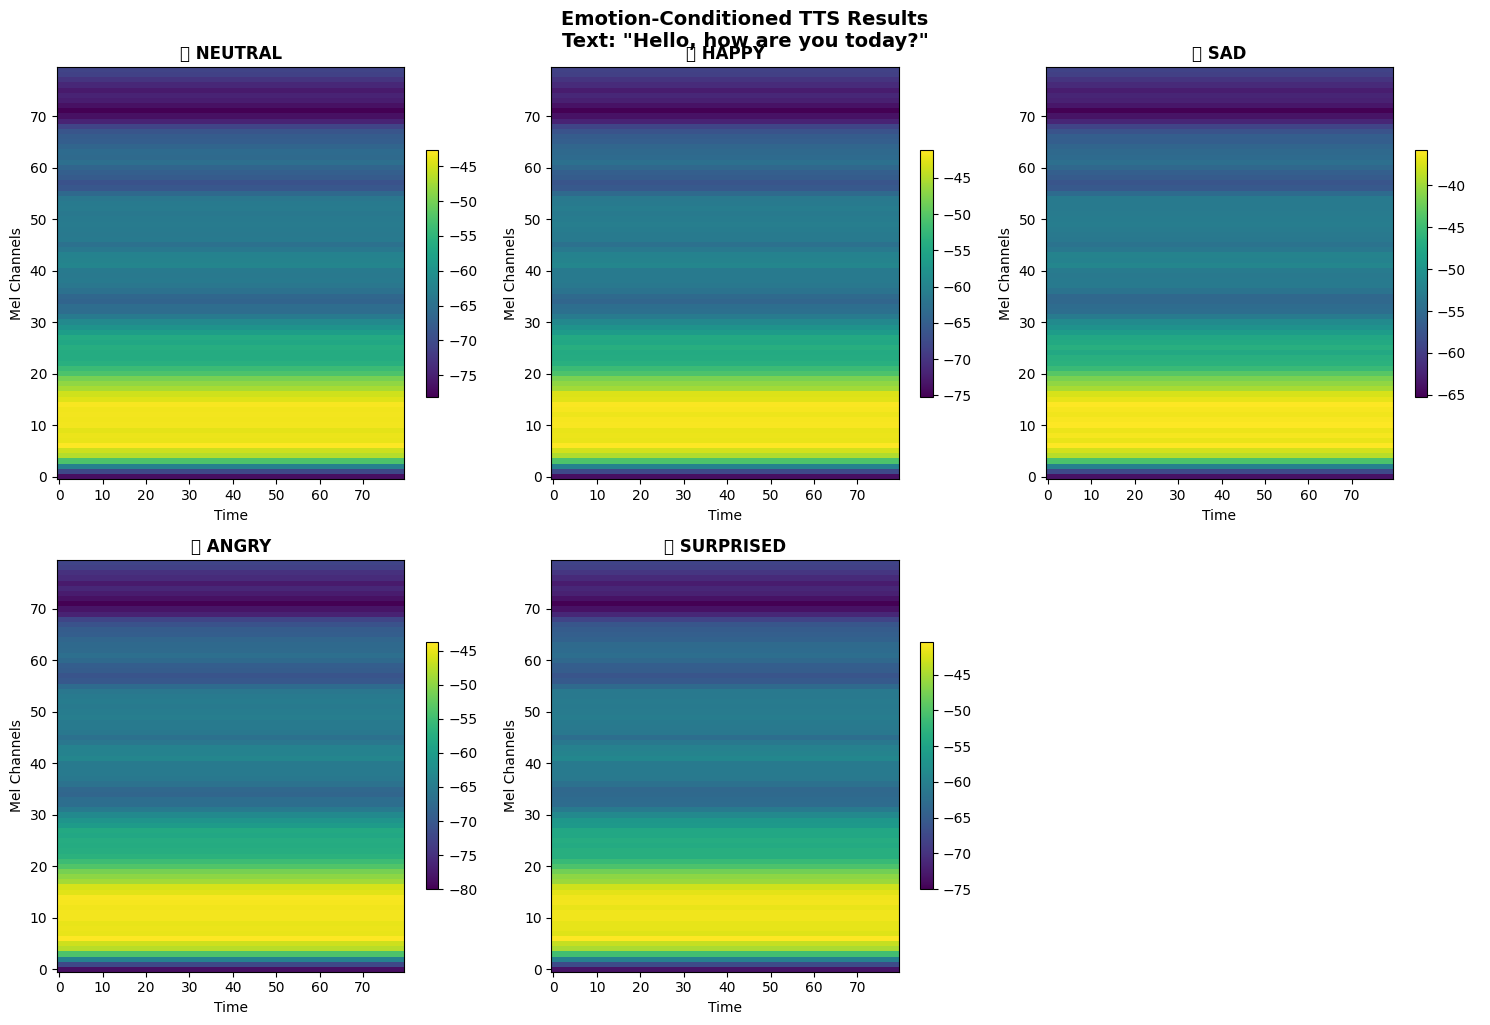


=== Emotion Statistics Comparison ===
     Emotion       Mean     Std        Min        Max
0    neutral -61.279999   9.885 -78.102997 -42.634998
1      happy -58.939999   9.484 -75.202003 -41.125999
2        sad -51.118000   8.250 -65.240997 -35.730999
3      angry -62.748001  10.124 -80.033997 -43.730999
4  surprised -58.631001   9.476 -75.013000 -40.487999


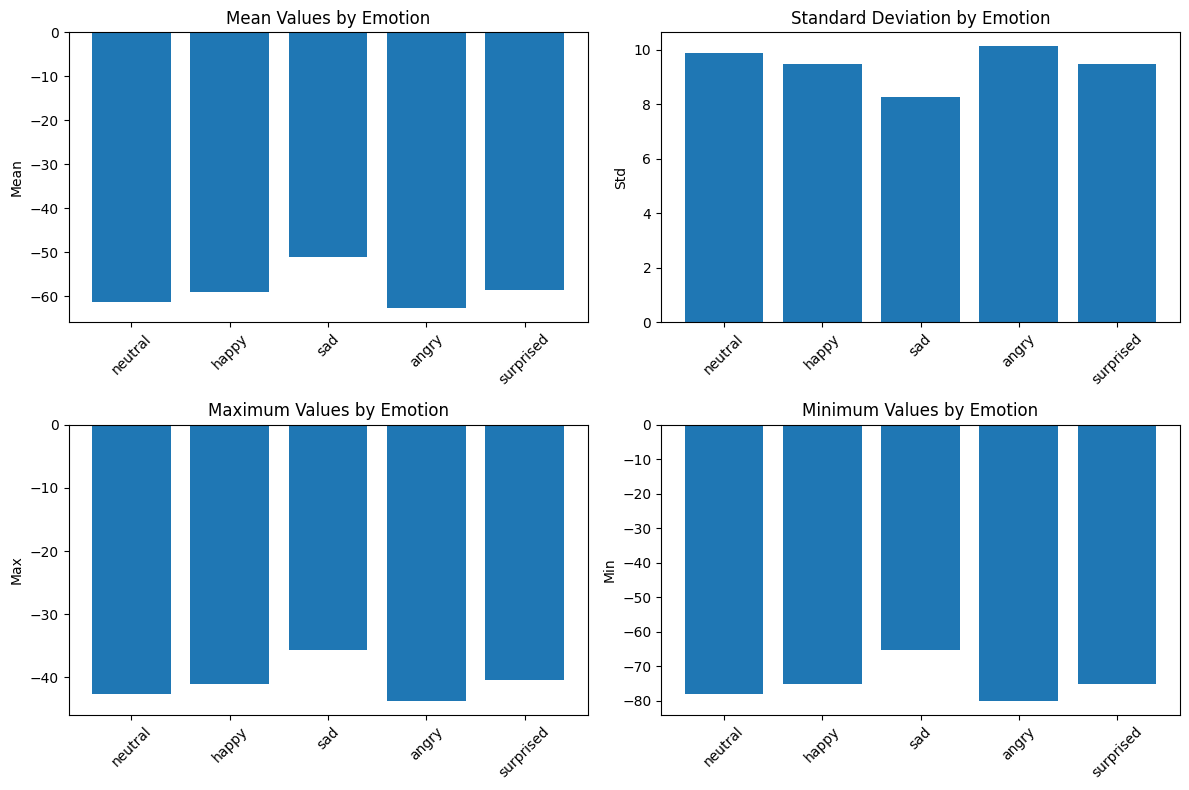

In [26]:
import numpy as np
import pandas as pd

# 감정별 멜 스펙트로그램 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, result in enumerate(emotion_results):
    if i < len(axes):
        mel = result['mel']
        emotion_name = result['emotion_name']

        im = axes[i].imshow(mel.T, aspect='auto', origin='lower', cmap='viridis')
        axes[i].set_title(f"🎭 {emotion_name.upper()}", fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Mel Channels')

        # 컬러바 추가
        plt.colorbar(im, ax=axes[i], shrink=0.6)

# 마지막 subplot 제거
if len(emotion_results) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.suptitle(f'Emotion-Conditioned TTS Results\nText: "{test_text}"',
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# 감정별 통계 비교
print("\n=== Emotion Statistics Comparison ===")
stats_data = []

for result in emotion_results:
    mel = result['mel']
    stats_data.append({
        'Emotion': result['emotion_name'],
        'Mean': mel.mean(),
        'Std': mel.std(),
        'Min': mel.min(),
        'Max': mel.max()
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df.round(3))

# 감정별 차이 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 평균값 비교
axes[0, 0].bar(stats_df['Emotion'], stats_df['Mean'])
axes[0, 0].set_title('Mean Values by Emotion')
axes[0, 0].set_ylabel('Mean')
axes[0, 0].tick_params(axis='x', rotation=45)

# 표준편차 비교
axes[0, 1].bar(stats_df['Emotion'], stats_df['Std'])
axes[0, 1].set_title('Standard Deviation by Emotion')
axes[0, 1].set_ylabel('Std')
axes[0, 1].tick_params(axis='x', rotation=45)

# 최대값 비교
axes[1, 0].bar(stats_df['Emotion'], stats_df['Max'])
axes[1, 0].set_title('Maximum Values by Emotion')
axes[1, 0].set_ylabel('Max')
axes[1, 0].tick_params(axis='x', rotation=45)

# 최소값 비교
axes[1, 1].bar(stats_df['Emotion'], stats_df['Min'])
axes[1, 1].set_title('Minimum Values by Emotion')
axes[1, 1].set_ylabel('Min')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()